In [4]:
import pandas as pd
from sqlalchemy import false
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score
import math
import itertools
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import numpy as np

In [5]:
team_df = pd.read_csv("data/team_index.csv")
programs_index = pd.read_csv('data/programs_index.csv')['program_id'].tolist()
team_never_get_medal_list = pd.read_csv("data/team_never_get_medal.csv")["NOC"].tolist()

In [6]:
team_no_data = []
number_each_medal = 329

In [7]:
def train_one(dataset, cross_val=False, cross_val_cv=5, val_method="neg_mean_squared_error"):
    X = dataset.drop(["Year", "NOC", "Gold_rate", "Silver_rate", "Bronze_rate", "Total_rate"], axis=1)
    Y = dataset[['Gold_rate', 'Silver_rate', 'Bronze_rate', 'Total_rate']]
    y_g = Y['Gold_rate']
    y_s = Y['Silver_rate']
    y_b = Y['Bronze_rate']
    y_t = Y["Total_rate"]
    # print(X, y_g)
    g = RandomForestRegressor(n_estimators=200)
    s = RandomForestRegressor(n_estimators=200)
    b = RandomForestRegressor(n_estimators=200)
    t = RandomForestRegressor(n_estimators=200)
    g.fit(X, y_g)
    s.fit(X, y_s)
    b.fit(X, y_b)
    t.fit(X, y_t)
    if cross_val:
        if cross_val_cv == -1:
            cross_val_cv = dataset.shape[0]
            # print("Cross validation cv is set to ", cross_val_cv)
        g_score = cross_val_score(g, X, y_g, cv=cross_val_cv, scoring=val_method)
        s_score = cross_val_score(s, X, y_s, cv=cross_val_cv, scoring=val_method)
        b_score = cross_val_score(b, X, y_b, cv=cross_val_cv, scoring=val_method)
        t_score = cross_val_score(t, X, y_t, cv=cross_val_cv, scoring=val_method)
        return g, s, b, t, g_score.mean(), s_score.mean(), b_score.mean(), t_score.mean()

    return g, s, b, t

In [8]:
def predict_one(data_set, model_g, model_s, model_b, model_t):
    X = data_set.drop(["Year", "NOC"], axis=1)
    y_g_pred = model_g.predict(X)
    y_s_pred = model_s.predict(X)
    y_b_pred = model_b.predict(X)
    y_t_pred = model_t.predict(X)
    df = pd.DataFrame()
    df["NOC"] = [data_set["NOC"].iloc[0]]
    df["Gold_rate"] = y_g_pred
    df["Silver_rate"] = y_s_pred
    df["Bronze_rate"] = y_b_pred
    df["Total_rate"] = y_t_pred
    return df

In [9]:
def constraint_func(x):
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return x

def rate_to_medal(rate_df, sum_num):
    rate_df["Gold_rate"] = rate_df["Gold_rate"].apply(constraint_func)
    rate_df["Silver_rate"] = rate_df["Silver_rate"].apply(constraint_func)
    rate_df["Bronze_rate"] = rate_df["Bronze_rate"].apply(constraint_func)
    rate_df["Total_rate"] = rate_df["Total_rate"].apply(constraint_func)
    rate_df["Gold"] = (rate_df["Gold_rate"] * sum_num).round()
    rate_df["Silver"] = (rate_df["Silver_rate"] * sum_num).round()
    rate_df["Bronze"] = (rate_df["Bronze_rate"] * sum_num).round()
    rate_df["Total"] = (rate_df["Total_rate"] * sum_num * 3).round()
    rate_df["Sum"] = rate_df["Gold"] + rate_df["Silver"] + rate_df["Bronze"]
    return rate_df

In [10]:
def sort_medal(df):
    df = df.sort_values(by=["Gold", "Sum"], ascending=False)
    #df["Rank"] = range(1, df.shape[0] + 1)
    return df

## 部分1 为每个国家单独建立模型评估，应用于特定国家

In [11]:
def train_model_each_team(cross_val=False, cross_val_cv=5, val_method="neg_mean_squared_error"):
    model_list = []
    predict_result_df = pd.DataFrame()
    team_sum = len(team_df)
    team_no_data = []
    tqdm_bar = tqdm(range(team_sum))
    g_score = 0
    s_score = 0
    b_score = 0
    t_score = 0
    for i in tqdm_bar:
        noc = team_df.iloc[i]["NOC"]
        try:
            df_train = pd.read_csv("data/dataset/train/" + noc + ".csv")
        except FileNotFoundError:
            team_no_data.append(noc)
            continue
        except pd.errors.EmptyDataError:
            team_no_data.append(noc)
            continue

        if df_train.shape[0] < 8 and cross_val:
            continue

        if cross_val:
            model_g, model_s, model_b, model_t, tmp_g_score, tmp_s_score, tmp_b_score, tmp_t_score = train_one(df_train, cross_val=True, cross_val_cv=cross_val_cv, val_method=val_method)
            model_list.append([noc, model_g, model_s, model_b, model_t])
            g_score += tmp_g_score
            s_score += tmp_s_score
            b_score += tmp_b_score
            t_score += tmp_t_score
        else:
            model_g, model_s, model_b, model_t = train_one(df_train)
            model_list.append([noc, model_g, model_s, model_b, model_t])

        tqdm_bar.set_description('Team [{}/{}], NOC: {} '.format(i+1, team_sum, noc))

    if cross_val:
        team_finish_num = len(model_list)
        g_score /= team_finish_num
        s_score /= team_finish_num
        b_score /= team_finish_num
        t_score /= team_finish_num
        print("Gold MSE: ", g_score)
        print("Silver MSE: ", s_score)
        print("Bronze MSE: ", b_score)
        print("Total MSE: ", t_score)
        return 

    return model_list, team_no_data

## 部分2 为所有国家建立相同的模型，并对特定国家进行评估

In [12]:
def train_model_all_team(cross_val=False, cross_val_cv=5, val_method="neg_mean_squared_error"):
    df_train_sum = pd.read_csv("data/dataset/train/sum_dataset.csv")
    model_g, model_s, model_b, model_t = train_one(df_train_sum)
    if cross_val:
        model_g, model_s, model_b, model_t, g_score, s_score, b_score, t_score = train_one(df_train_sum, cross_val=True, cross_val_cv=cross_val_cv, val_method=val_method)
        print("Gold " + val_method + ": ", g_score)
        print("Silver " + val_method + ": ", s_score)
        print("Bronze " + val_method + ": ", b_score)
        print("Total " + val_method + ": ", t_score)
        return 
    else:
        return [model_g, model_s, model_b, model_t]

In [13]:
def predict(model_single_list_, model_all, rate=0.5):
    predict_result_df = pd.DataFrame()
    for model_single in model_single_list_:
        noc = model_single[0]
        model_g = model_single[1]
        model_s = model_single[2]
        model_b = model_single[3]
        model_t = model_single[4]
        df_predict = pd.read_csv("data/dataset/predict/" + noc + ".csv")
        tmp_single = predict_one(df_predict, model_g, model_s, model_b, model_t)
        tmp_all = predict_one(df_predict, model_all[0], model_all[1], model_all[2], model_all[3])
        tmp_result = pd.DataFrame()
        tmp_result["NOC"] = [noc]
        tmp_result["Gold_rate"] = tmp_single["Gold_rate"] * rate + tmp_all["Gold_rate"] * (1 - rate)
        tmp_result["Silver_rate"] = tmp_single["Silver_rate"] * rate + tmp_all["Silver_rate"] * (1 - rate)
        tmp_result["Bronze_rate"] = tmp_single["Bronze_rate"] * rate + tmp_all["Bronze_rate"] * (1 - rate)
        tmp_result["Total_rate"] = tmp_single["Total_rate"] * rate + tmp_all["Total_rate"] * (1 - rate)
        predict_result_df = pd.concat([predict_result_df, tmp_result], ignore_index=True)
    return predict_result_df

# Verify the Models

In [77]:
train_model_all_team(cross_val=True, cross_val_cv=5)

Gold neg_mean_squared_error:  -0.00025702141297956875
Silver neg_mean_squared_error:  -0.00015032226480717108
Bronze neg_mean_squared_error:  -9.57939030726752e-05
Total neg_mean_squared_error:  -0.00015484424171193978


In [78]:
train_model_each_team(cross_val=True, cross_val_cv=-1) # 对每个队伍单独建立模型

Team [206/206], NOC: LES : 100%|██████████| 206/206 [18:58<00:00,  5.53s/it]

Gold MSE:  -6.048879073543516e-05
Silver MSE:  -4.7091456947223895e-05
Bronze MSE:  -4.605929475866713e-05
Total MSE:  -3.0079428827261018e-05


In [79]:
train_model_all_team(cross_val=True, cross_val_cv=5, val_method="r2")

Gold r2:  0.41895060497149766
Silver r2:  0.4884334607606681
Bronze r2:  0.6529158349263671
Total r2:  0.5915516830311522


In [80]:
# train_model_each_team(cross_val=True, cross_val_cv=2, val_method="r2") # 对每个队伍单独建立模型

# 获取项目权重

In [2]:
def get_weight(noc, single_model_list, without_host=False):
    weight_df = pd.DataFrame()
    for single_models in single_model_list:
        if single_models[0] == noc:
            if not without_host:
                tmp_df = pd.DataFrame()
                tmp_df["NOC"] = [noc]
                tmp_df["Feature"] = ["Host"]
                tmp_df["Gold"] = single_models[1].feature_importances_[0]
                tmp_df["Silver"] = single_models[2].feature_importances_[0]
                tmp_df["Bronze"] = single_models[3].feature_importances_[0]
                tmp_df["Total"] = single_models[4].feature_importances_[0]
                weight_df = pd.concat([weight_df, tmp_df], ignore_index=True)

            for i in range(len(single_models[1].feature_importances_) - 1):
                tmp_df = pd.DataFrame()
                tmp_df["NOC"] = [noc]
                tmp_df["Feature"] = [programs_index[i]]
                tmp_df["Gold"] = single_models[1].feature_importances_[i + 1]
                tmp_df["Silver"] = single_models[2].feature_importances_[i + 1]
                tmp_df["Bronze"] = single_models[3].feature_importances_[i + 1]
                tmp_df["Total"] = single_models[4].feature_importances_[i + 1]
                weight_df = pd.concat([weight_df, tmp_df], ignore_index=True)
            return weight_df
    return weight_df

# Train model and predict

In [14]:

print("Start training single model")
model_single_list, no_data_list = train_model_each_team() # 对每个队伍单独建立模型
print("Done")

print("Start training all_team model")
model_all_list = train_model_all_team()                   # 对所有队伍建立模型
print("Done")

print("Start predicting")
predict_result = predict(model_single_list, model_all_list) # 预测并进行模型结果平均
print("Done")

Start training single model


Team [206/206], NOC: LES : 100%|██████████| 206/206 [02:20<00:00,  1.47it/s]


Done
Start training all_team model
Done
Start predicting
Done


# Question 1: The medal count in 2028

In [83]:
predict_result = rate_to_medal(predict_result, number_each_medal)
medal_tops = sort_medal(predict_result)
# medal_tops = medal_tops[["NOC", "Gold", "Silver", "Bronze", "Sum"]]
medal_tops.head(10)
medal_tops.to_csv("output/medal_count_in_2028.csv")

# Question 2: The most potential team to get their first medal in 2028

In [84]:
def train_MWPM(data_set, val=False, test_size=0.2):
    model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000, activation="relu", random_state=42)
    X = data_set.drop(["Year", "NOC", "Total_rate"], axis=1)
    Y = data_set["Total_rate"]
    
    # over sampling to balance the data
    ros = RandomUnderSampler(random_state=42)
    X, Y = ros.fit_resample(X, Y)

    if val:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=True, random_state=42)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
        cm = confusion_matrix(Y_test, Y_pred)
        auc_score = auc(fpr, tpr)
        return auc_score, cm, fpr, tpr, accuracy_score(Y_test, Y_pred)
    model.fit(X, Y)
    return model

def predict_MWPM(data_set, model):
    X = data_set.drop(["Year", "NOC"], axis=1)
    Y = model.predict_proba(X)[:, 1]
    return Y

In [85]:
def draw_ROC(fpr, tpr, auc_score): # by https://blog.csdn.net/Joker00007/article/details/120626775
    plt.style.use('default')
    plt.figure(figsize=(6, 6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label='Val AUC = %0.3f' % auc_score)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.savefig("output/ROC.eps")
    plt.show()

def plot_confusion_matrix(confusion_mat): # by http://www.simyng.com/index.php/archives/96/
    # 画混淆矩阵图，配色风格使用cm.Greens
    plt.style.use('default')
    plt.imshow(confusion_mat,interpolation='nearest',cmap="winter") 
    
    # 显示colorbar
    plt.colorbar()
    
    # 使用annotate在图中显示混淆矩阵的数据
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # 第一个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度

    plt.title('Confusion Matrix')     # 图标title
    plt.ylabel('True label')          # 坐标轴标签
    plt.xlabel('Predicted label')     # 坐标轴标签
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.savefig("output/Confusion_Matrix.eps")
    plt.show()
    
    

In [86]:
classify_dataset = pd.read_csv("data/dataset/train/classify_dataset.csv")

# Verify the model

In [87]:
w_aux, w_cm, w_fpr, w_tpr, w_ac = train_MWPM(classify_dataset, val=True, test_size=0.20)
print("AUC: ", w_aux)
print("Accuracy: ", w_ac)

AUC:  0.9486916577803297
Accuracy:  0.9265175718849841


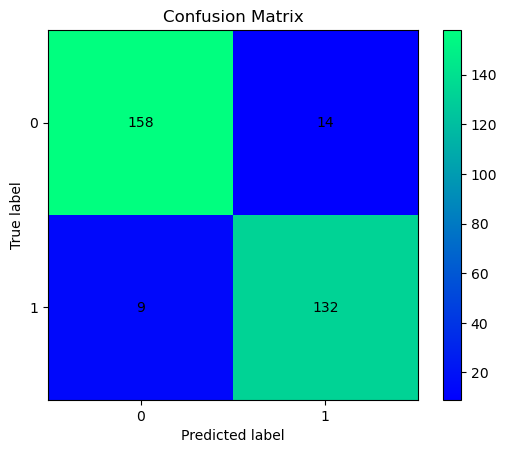

In [88]:
plot_confusion_matrix(w_cm)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


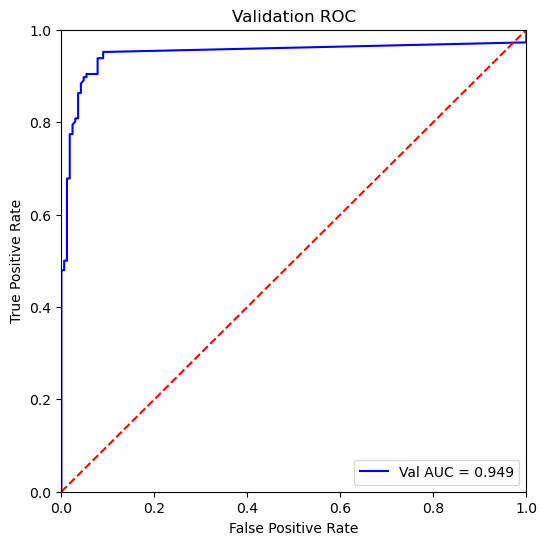

In [89]:
draw_ROC(w_fpr, w_tpr, w_aux)

In [90]:
WGMM_model = train_MWPM(classify_dataset)

classify_result_df = pd.DataFrame()
for each_noc in team_df["NOC"].to_list():
    try:
        df = pd.read_csv("data/dataset/predict/" + each_noc + ".csv")
    except FileNotFoundError:
        continue
    except pd.errors.EmptyDataError:
        continue
    result_df = pd.DataFrame()
    result_df["NOC"] = [each_noc]
    result_df["Medal_rate"] = predict_MWPM(df, WGMM_model)
    classify_result_df = pd.concat([classify_result_df, result_df], ignore_index=True)

team_never_get_medal_df = classify_result_df[classify_result_df["NOC"].isin(team_never_get_medal_list)]
team_never_get_medal_df = team_never_get_medal_df.sort_values(by="Medal_rate", ascending=False)

In [91]:
team_never_get_medal_df.head(10)

,NOC,Medal_rate
167,PRK,1.000000
183,ZAM,0.486610
75,CIV,0.467491
28,NGR,0.182116
99,PUR,0.176461
142,MDA,0.038148
14,CHA,0.018615
158,TLS,0.018615
168,SOL,0.018615
166,CAM,0.018615


# Question 3: The importance of each program in each country

In [3]:
weight = get_weight("CHN", model_single_list, without_host=False) # 重要性，输谁查谁
weight.to_csv("output/weight_jpn.csv")

NameError: name 'model_single_list' is not defined